In [96]:
DEV = True

In [149]:
import os
import getpass
import numpy as np
import pandas as pd
from numpy.random import seed
seed(1)

project_path = project_path = 'C:/Users/' + getpass.getuser() + '/Desktop/10 - Thesis/cycle_prediction/'
project_exist = os.path.exists(project_path)
if project_exist and DEV:
    import sys
    sys.path.insert(0, project_path)
    print('development mode')
else:
    print('user mode')
    
import cycle_prediction
print(cycle_prediction.__version__)
from cycle_prediction.t2e import t2e
from cycle_prediction.weibull_utils import plot_top_predictions

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
import pickle
import warnings
warnings.filterwarnings("ignore")
import os
%load_ext autoreload
%autoreload 2

development mode
1.2.0
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [139]:
path = 'C:/Users/ebasfad/Desktop/10 - Thesis/cycle_prediction/data/bpic13/'

flist = os.listdir(path)
dfs = pd.DataFrame()

for f in flist:
    df = pd.read_csv(path + f, delimiter=';')
    
    if 'incidents.csv' in f:
        df['type'] = 'incident'
    elif 'problems.csv' in f:
        df['type'] = 'problem'
#     if 'open' in 'f':
#         dfs.iloc[:,0] = dfs.iloc[:,0] +'1'
    dfs = pd.concat([dfs, df], axis=0)

dfs = dfs.loc[:, ['Case ID','Activity','Complete Timestamp','impact', 'type']]
dfs['Complete Timestamp'] = pd.to_datetime(dfs['Complete Timestamp'])
# dfs = dfs.reset_index()
dfs.drop_duplicates(subset=['Case ID', 'Activity', 'Complete Timestamp'], ,inplace=True)
print(dfs.shape)
print(dfs[dfs.columns[0]].nunique())
dfs.tail(2)

(72993, 5)
9395


,Case ID,Activity,Complete Timestamp,impact,type
2349,1-759318221,Accepted-In Progress,2012-06-15 12:17:18,Medium,problem
2350,1-759318221,Accepted-Assigned,2012-06-15 12:19:56,Medium,problem


In [129]:
def duration(df):
    return (df['Complete Timestamp'].max() - df['Complete Timestamp'].min()).total_seconds()/86400

<AxesSubplot:xlabel='duration', ylabel='type'>

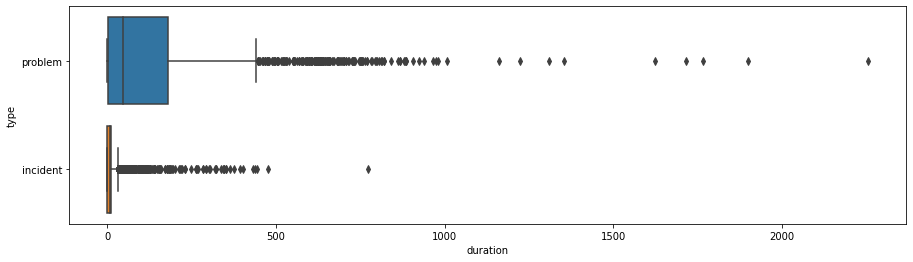

In [130]:
tmp = pd.DataFrame(dfs.groupby('Case ID').apply(lambda x: [duration(x), x['type'].unique()[0]]))
tmp = pd.DataFrame(tmp[0].to_list(), columns=['duration','type'])
plt.figure(figsize=(15,4))
sns.boxplot(x=tmp['duration'], y=tmp['type'], orient='h')

<AxesSubplot:xlabel='duration', ylabel='impact'>

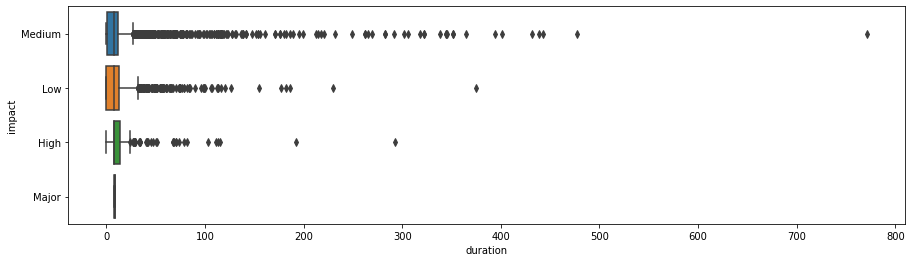

In [131]:
tmp = dfs.loc[dfs['type'] == 'incident']
tmp = pd.DataFrame(tmp.groupby('Case ID').apply(lambda x: [duration(x), x['impact'].unique()[0]]))
tmp = pd.DataFrame(tmp[0].to_list(), columns=['duration','impact'])
plt.figure(figsize=(15,4))
sns.boxplot(x=tmp['duration'], y=tmp['impact'], orient='h')

<AxesSubplot:xlabel='duration', ylabel='impact'>

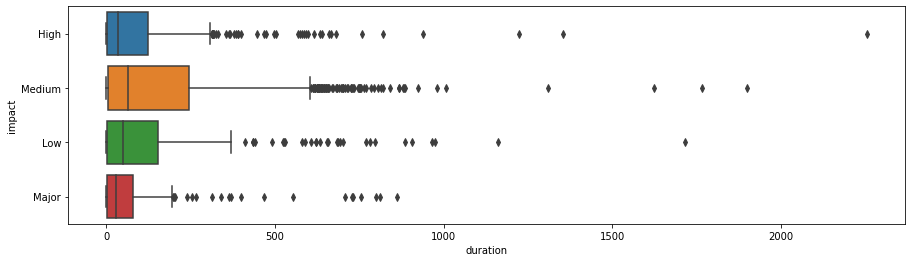

In [132]:
tmp = dfs.loc[dfs['type'] == 'problem']
tmp = pd.DataFrame(tmp.groupby('Case ID').apply(lambda x: [duration(x), x['impact'].unique()[0]]))
tmp = pd.DataFrame(tmp[0].to_list(), columns=['duration','impact'])
plt.figure(figsize=(15,4))
sns.boxplot(x=tmp['duration'], y=tmp['impact'], orient='h')

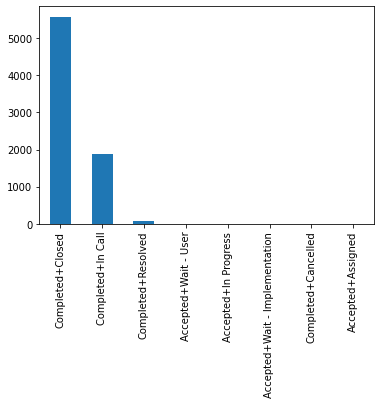

In [133]:
path = 'C:/Users/ebasfad/Desktop/10 - Thesis/cycle_prediction/data/bpic13/'
dfs = pd.read_csv(path + 'bpi_challenge_2013_incidents.csv', delimiter=';')
dfs['Complete Timestamp'] = pd.to_datetime(dfs['Complete Timestamp'])
dfs = dfs.sort_values(by='Complete Timestamp')
dfs.drop_duplicates(subset=['Case ID'],keep='last')['Activity'].value_counts().plot(kind='bar');

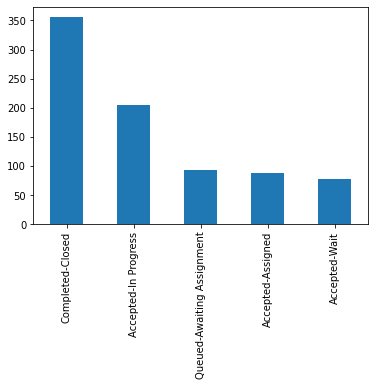

In [143]:
path = 'C:/Users/ebasfad/Desktop/10 - Thesis/cycle_prediction/data/bpic13/'
dfs = pd.read_csv(path + 'bpi_challenge_2013_open_problems.csv', delimiter=';')
dfs['Complete Timestamp'] = pd.to_datetime(dfs['Complete Timestamp'])
dfs = dfs.sort_values(by='Complete Timestamp')
dfs.drop_duplicates(subset=['Case ID'],keep='last')['Activity'].value_counts().plot(kind='bar');

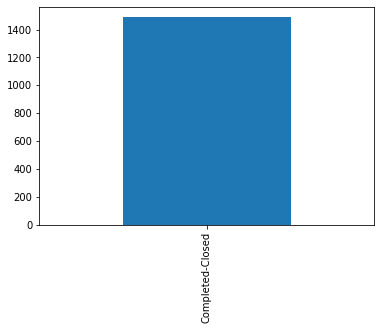

In [135]:
path = 'C:/Users/ebasfad/Desktop/10 - Thesis/cycle_prediction/data/bpic13/'
dfs = pd.read_csv(path + 'bpi_challenge_2013_closed_problems.csv', delimiter=';')
dfs['Complete Timestamp'] = pd.to_datetime(dfs['Complete Timestamp'])
dfs = dfs.sort_values(by='Complete Timestamp')
dfs.drop_duplicates(subset=['Case ID'],keep='last')['Activity'].value_counts().plot(kind='bar');

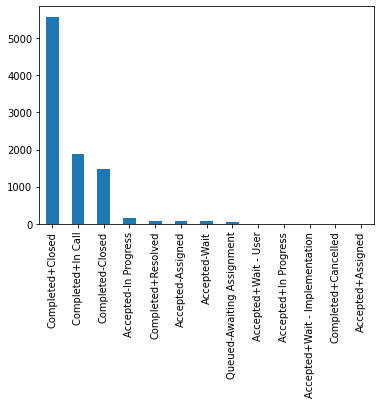

In [144]:
path = 'C:/Users/ebasfad/Desktop/10 - Thesis/cycle_prediction/data/bpic13_all.csv'
dfs = pd.read_csv(path)
dfs['CompleteTimestamp'] = pd.to_datetime(dfs['CompleteTimestamp'])
dfs = dfs.sort_values(by='CompleteTimestamp')
dfs.drop_duplicates(subset=['CaseID'],keep='last')['ActivityID'].value_counts().plot(kind='bar');

In [137]:
# for col in dfs.columns[2:]:
#     try:
#         plt.figure()
#         dfs[col] = dfs[col].fillna('Unknown')
#         x, h = np.unique(dfs[col],return_counts=True)
#         if len(x) > 40:
#             print(col, len(x))
#             continue
#         plt.bar(x= x, height=h)
#         plt.xticks(rotation=45, ha='right')
#         nupc = max(dfs.groupby([dfs.columns[0]]).nunique()[col].unique())
#         plt.title(col + '  nunique: ' + str(dfs[col].nunique()) + '  per case: ' + str(nupc))
#         plt.show()
#     except:
#         print(col)
#         pass

[]

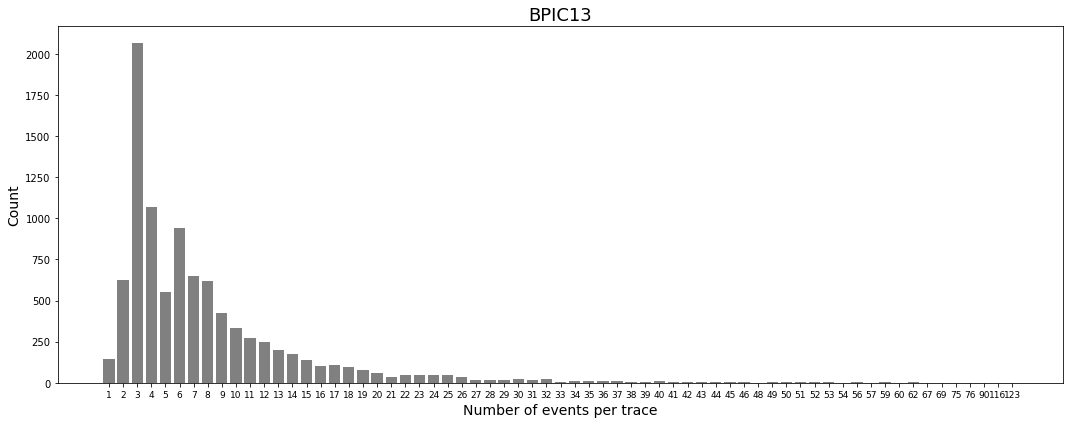

In [140]:
fig = plt.figure(figsize=(15, 6)) 
sns.countplot(dfs.groupby(["Case ID"]).agg({"Activity":'count'})["Activity"], color='gray')
plt.xticks(rotation=0, fontsize=9)
plt.xlabel("Number of events per trace", fontsize=14)
plt.ylabel("Count",fontsize=14)
plt.title("BPIC13",fontsize=18)
plt.tight_layout()
plt.plot()

In [141]:
dfs.rename(columns={
    'Case ID': 'CaseID',
    'Activity': 'ActivityID',
    'Complete Timestamp': 'CompleteTimestamp'
}, inplace=True)

In [142]:
dfs.to_csv('../data/bpic13_all.csv', index=False)